## Custom OCR training a neural network

In [1]:
import tensorflow
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


print(tensorflow.__version__)

2023-08-09 13:50:53.364978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0


## Loading MNIST (0-9) dataset

In [2]:
from tensorflow.keras.datasets import mnist
import ssl

# deactivate ssl verification
ssl._create_default_https_context = ssl._create_unverified_context


(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# 60.000 images for training and 10.000 images for testing
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
# we join the training and test sets to join them with the next dataset
digits_data = np.vstack([x_train, x_test])
digits_labels = np.hstack([y_train, y_test])

print(digits_data.shape)
print(digits_labels.shape)

(70000, 28, 28)
(70000,)


Text(0.5, 1.0, 'Class: 9')

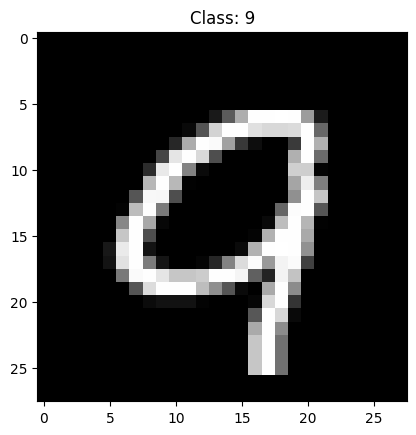

In [5]:
plt.imshow(digits_data[3000], cmap='gray')
plt.title('Class: ' + str(digits_labels[3000]))

<Axes: ylabel='count'>

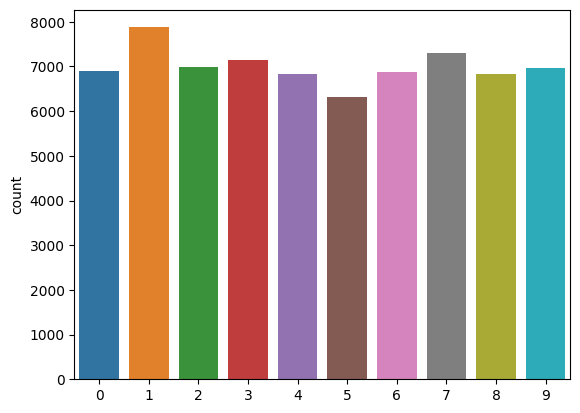

In [6]:
sns.countplot(x=digits_labels)

## Loading Kaggle A-Z dataset

In [7]:
dataset = pd.read_csv('AZ-letters.csv')

(372450, 28, 28)
(372450,)


Text(0.5, 1.0, 'Class 13')

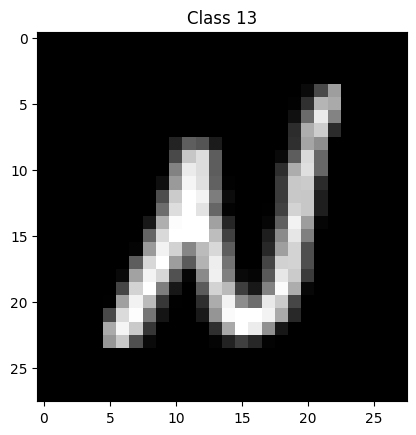

In [8]:
# all the columns except the one named '0'
alphabet_data = dataset.drop('0', axis=1)
alphabet_labels = dataset['0']

alphabet_data = np.reshape(alphabet_data.values, (alphabet_data.shape[0], 28, 28))

print(alphabet_data.shape)
print(alphabet_labels.shape)

index = np.random.randint(0, alphabet_data.shape[0])
plt.imshow(alphabet_data[index], cmap='gray')
plt.title('Class ' + str(alphabet_labels[index]))


<Axes: xlabel='0', ylabel='count'>

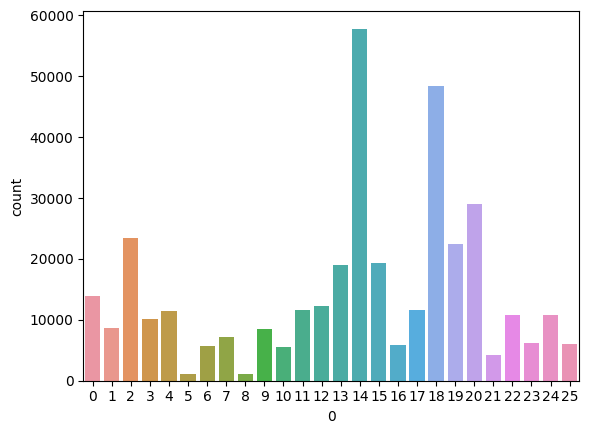

In [9]:
sns.countplot(x=alphabet_labels)

## Joining both datasets

In [10]:
# increment the values
alphabet_labels += 10

print(alphabet_labels, np.unique(alphabet_labels))

data = np.vstack([alphabet_data, digits_data])
labels = np.hstack([alphabet_labels, digits_labels])
print(data.shape, labels.shape)

data = np.array(data, dtype='float32')
data = np.expand_dims(data, axis=-1)
print(data.shape)

0         10
1         10
2         10
3         10
4         10
          ..
372445    35
372446    35
372447    35
372448    35
372449    35
Name: 0, Length: 372450, dtype: int64 [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35]
(442450, 28, 28) (442450,)
(442450, 28, 28, 1)


## Pre-processing the data

In [11]:
data[0].min(), data[0].max()

(0.0, 255.0)

In [12]:
# normalise the data
data /= 255.0

In [13]:
data[0].min(), data[0].max()

(0.0, 1.0)

In [14]:
np.unique(labels), len(np.unique(labels))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 36)

In [15]:
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [16]:
np.unique(labels)

array([0, 1])

Text(0.5, 1.0, '[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]')

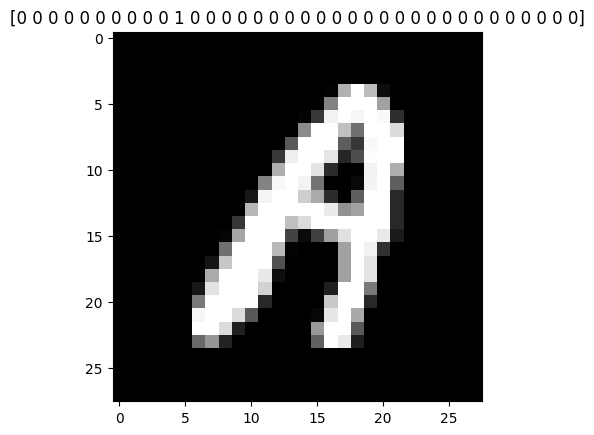

In [17]:
plt.imshow(data[0].reshape(28,28), cmap='gray')
plt.title(str(labels[0]))

In [18]:
classes_total = labels.sum(axis=0)
classes_total

array([ 6903,  7877,  6990,  7141,  6824,  6313,  6876,  7293,  6825,
        6958, 13869,  8668, 23409, 10134, 11440,  1163,  5762,  7218,
        1120,  8493,  5603, 11586, 12336, 19010, 57825, 19341,  5812,
       11566, 48419, 22495, 29008,  4182, 10784,  6272, 10859,  6076])

In [19]:
classes_total.max()

57825

In [21]:
classes_weight = {}
for i in range(0, len(classes_total)):
  classes_weight[i] = classes_total.max() / classes_total[i]

In [22]:
classes_weight

{0: 8.376792698826597,
 1: 7.340992763742541,
 2: 8.272532188841202,
 3: 8.097605377398123,
 4: 8.473769050410317,
 5: 9.15967052114684,
 6: 8.409685863874346,
 7: 7.928835870012341,
 8: 8.472527472527473,
 9: 8.310577752227651,
 10: 4.169370538611291,
 11: 6.671089063221043,
 12: 2.4702037677816224,
 13: 5.7060390763765545,
 14: 5.0546328671328675,
 15: 49.72055030094583,
 16: 10.035577924331829,
 17: 8.011221945137157,
 18: 51.629464285714285,
 19: 6.808548216178029,
 20: 10.320364090665715,
 21: 4.990937338166753,
 22: 4.6875,
 23: 3.0418200946870066,
 24: 1.0,
 25: 2.989762680316426,
 26: 9.94924294562973,
 27: 4.999567698426422,
 28: 1.1942625828703608,
 29: 2.5705712380529007,
 30: 1.993415609487038,
 31: 13.827116212338593,
 32: 5.362110534124629,
 33: 9.21954719387755,
 34: 5.3250759738465785,
 35: 9.51695194206715}

In [24]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1, stratify=labels)

In [25]:
x_train.shape, x_test.shape

((353960, 28, 28, 1), (88490, 28, 28, 1))

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(rotation_range=10, zoom_range=0.05, width_shift_range=0.1, height_shift_range=0.1, 
                                  horizontal_flip=False)

## Building the neural network

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

network = Sequential()

# first convolutional layer
network.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
network.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer
network.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
network.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer
network.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
network.add(MaxPooling2D(pool_size=(2, 2)))

# convert the matrix into a vector
network.add(Flatten())

# first dense layer
network.add(Dense(units=64, activation='relu'))
network.add(Dense(units=128, activation='relu'))

# output layer
network.add(Dense(units=36, activation='softmax'))


network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

In [32]:
name_labels = '0123456789'
name_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
name_labels = [l for l in name_labels]

In [33]:
print(name_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Training the neural network

In [34]:
# indicates the path to the dataset
file_model = 'custom-ocr.model'

# indicates how many times the dataset is passed forward and backward through the neural network
# indicates the training iterations
epochs = 20

# indicates how many images to process at a time
batch_size = 128

In [35]:
len(x_train) // batch_size

2765

In [36]:
checkpointer = ModelCheckpoint(file_model, monitor='val_loss', verbose=1, save_best_only=True)

history = network.fit(augmentation.flow(x_train, y_train, batch_size=batch_size),
                      validation_data=(x_test, y_test),
                      steps_per_epoch=len(x_train) // batch_size, epochs=epochs,
                      class_weight=classes_weight, verbose=1, callbacks=[checkpointer])

Epoch 1/20
2765/2765 [==============================] - ETA: 0s - loss: 2.1111 - accuracy: 0.8271
Epoch 1: val_loss improved from inf to 0.20860, saving model to custom-ocr.model
INFO:tensorflow:Assets written to: custom-ocr.model/assets


INFO:tensorflow:Assets written to: custom-ocr.model/assets


2765/2765 [==============================] - 280s 100ms/step - loss: 2.1111 - accuracy: 0.8271 - val_loss: 0.2086 - val_accuracy: 0.9233
Epoch 2/20
2765/2765 [==============================] - ETA: 0s - loss: 0.9474 - accuracy: 0.9020
Epoch 2: val_loss improved from 0.20860 to 0.20558, saving model to custom-ocr.model
INFO:tensorflow:Assets written to: custom-ocr.model/assets


INFO:tensorflow:Assets written to: custom-ocr.model/assets


2765/2765 [==============================] - 293s 106ms/step - loss: 0.9474 - accuracy: 0.9020 - val_loss: 0.2056 - val_accuracy: 0.9304
Epoch 3/20
2765/2765 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.9148
Epoch 3: val_loss did not improve from 0.20558
2765/2765 [==============================] - 246s 89ms/step - loss: 0.7981 - accuracy: 0.9148 - val_loss: 0.2145 - val_accuracy: 0.9076
Epoch 4/20
2765/2765 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.9220
Epoch 4: val_loss did not improve from 0.20558
2765/2765 [==============================] - 242s 87ms/step - loss: 0.7061 - accuracy: 0.9220 - val_loss: 0.2826 - val_accuracy: 0.8703
Epoch 5/20
2765/2765 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.9271
Epoch 5: val_loss did not improve from 0.20558
2765/2765 [==============================] - 259s 94ms/step - loss: 0.6469 - accuracy: 0.9271 - val_loss: 0.2206 - val_accuracy: 0.9083
Epoch 6/20
2765/2765

INFO:tensorflow:Assets written to: custom-ocr.model/assets


2765/2765 [==============================] - 237s 86ms/step - loss: 0.4597 - accuracy: 0.9443 - val_loss: 0.1829 - val_accuracy: 0.9190
Epoch 14/20
2765/2765 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.9450
Epoch 14: val_loss improved from 0.18294 to 0.13514, saving model to custom-ocr.model
INFO:tensorflow:Assets written to: custom-ocr.model/assets


INFO:tensorflow:Assets written to: custom-ocr.model/assets


2765/2765 [==============================] - 240s 87ms/step - loss: 0.4504 - accuracy: 0.9450 - val_loss: 0.1351 - val_accuracy: 0.9554
Epoch 15/20
2765/2765 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.9462
Epoch 15: val_loss improved from 0.13514 to 0.12898, saving model to custom-ocr.model
INFO:tensorflow:Assets written to: custom-ocr.model/assets


INFO:tensorflow:Assets written to: custom-ocr.model/assets


2765/2765 [==============================] - 306s 111ms/step - loss: 0.4446 - accuracy: 0.9462 - val_loss: 0.1290 - val_accuracy: 0.9604
Epoch 16/20
2765/2765 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.9472
Epoch 16: val_loss did not improve from 0.12898
2765/2765 [==============================] - 337s 122ms/step - loss: 0.4340 - accuracy: 0.9472 - val_loss: 0.1433 - val_accuracy: 0.9460
Epoch 17/20
2765/2765 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.9491
Epoch 17: val_loss did not improve from 0.12898
2765/2765 [==============================] - 286s 104ms/step - loss: 0.4191 - accuracy: 0.9491 - val_loss: 0.1448 - val_accuracy: 0.9496
Epoch 18/20
2765/2765 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.9492
Epoch 18: val_loss did not improve from 0.12898
2765/2765 [==============================] - 284s 103ms/step - loss: 0.4163 - accuracy: 0.9492 - val_loss: 0.1482 - val_accuracy: 0.9512
Epoch 19/20

INFO:tensorflow:Assets written to: custom-ocr.model/assets


2765/2765 [==============================] - 247s 89ms/step - loss: 0.4065 - accuracy: 0.9508 - val_loss: 0.1182 - val_accuracy: 0.9623
Epoch 20/20
2765/2765 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.9503
Epoch 20: val_loss did not improve from 0.11816
2765/2765 [==============================] - 234s 85ms/step - loss: 0.4101 - accuracy: 0.9503 - val_loss: 0.1537 - val_accuracy: 0.9424


## Evaluating the neural network

In [37]:
predictions = network.predict(x_test, batch_size=1)
predictions[0]

# total predictions
len(predictions[0])

# get the highest probability 
np.argmax(predictions[0])

88490/88490 [==============================] - 230s 3ms/step


24

In [38]:
network.evaluate(x_test, y_test)

2766/2766 [==============================] - 24s 9ms/step - loss: 0.1537 - accuracy: 0.9424


[0.1537484973669052, 0.9424116015434265]

In [39]:
test_argmax = y_test.argmax(axis=1)
predictions_argmax = predictions.argmax(axis=1)
report = classification_report(test_argmax, predictions_argmax, target_names=name_labels)

print(report)

              precision    recall  f1-score   support

           0       0.29      0.78      0.42      1381
           1       0.97      0.99      0.98      1575
           2       0.90      0.97      0.93      1398
           3       0.98      0.99      0.98      1428
           4       0.89      0.98      0.93      1365
           5       0.73      0.94      0.82      1263
           6       0.96      0.98      0.97      1375
           7       0.97      0.99      0.98      1459
           8       0.93      0.99      0.96      1365
           9       0.95      0.99      0.97      1392
           A       1.00      0.98      0.99      2774
           B       0.99      0.98      0.98      1734
           C       0.99      0.98      0.99      4682
           D       0.93      0.97      0.95      2027
           E       0.98      0.99      0.99      2288
           F       0.95      1.00      0.97       233
           G       0.96      0.95      0.96      1152
           H       0.96    

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

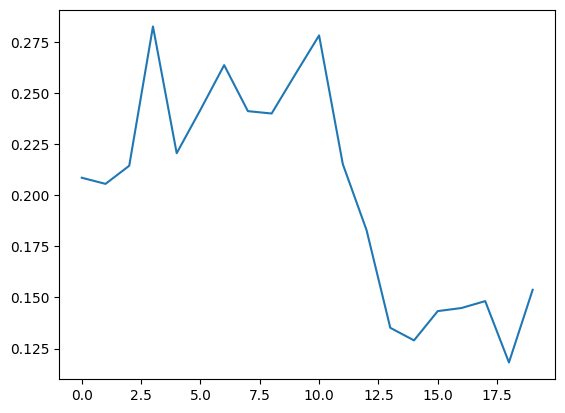

In [41]:
# how many errors are in the predictions 

"""
Si la curva de pérdida de validación disminuye gradualmente 
y se estabiliza a medida que aumentan las épocas, indica que el 
modelo está aprendiendo correctamente y generalizando bien a datos nuevos.
"""

"""
Si la curva de pérdida de validación comienza a aumentar después de un punto,
puede indicar que el modelo está sobreajustando los datos de entrenamiento y no generaliza bien.
Para resolver esto, aumentar los epochs
"""

plt.plot(history.history['val_loss'])

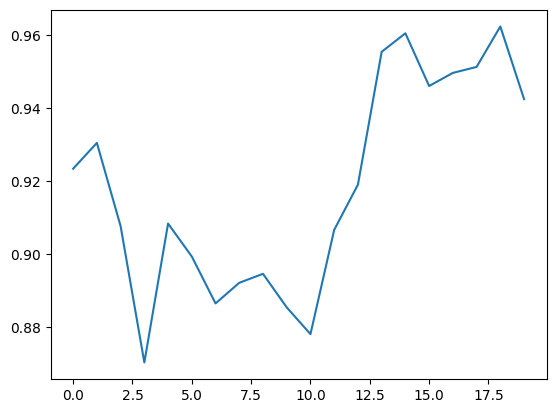

In [42]:
## Plot the accuracy
plt.plot(history.history['val_accuracy'])

## Saving the neural network

In [44]:
network.save('custom-ocr-network', save_format='h5')

/Users/damianstone/Documents/Code/courses/python/OCR/venv-ocr/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing the neural network with images

In [46]:
from tensorflow.keras.models import load_model

loaded_network = load_model('./custom-ocr-network')

loaded_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

(571, 648)
(28, 28, 1)
(1, 28, 28, 1)


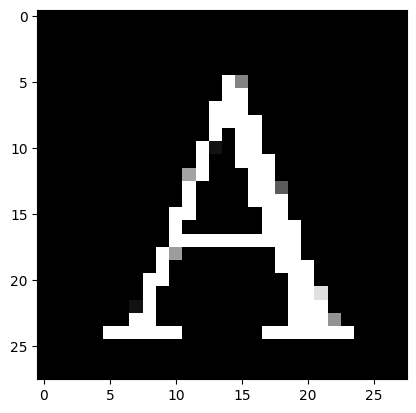

In [78]:
import cv2

img = cv2.imread('../images/A.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

value, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
print(thresh.shape) #  1200 x 12000

# transform to 28 x 28 for the model
resized = cv2.resize(thresh, (28, 28))

# normalize the image
resized = resized.astype('float32') / 255
resized = np.expand_dims(resized, axis=-1)
print(resized.shape)

# reshape to be (1, 28, 28, 1) cuz the model expects a batch of images, in this case just one image
reshaped = np.reshape(resized, (1, 28, 28, 1))
print(reshaped.shape)


plt.imshow(resized, cmap='gray')
plt.show()

In [82]:
prediction = loaded_network.predict(reshaped)
print(prediction)

# get the index of the highest prediction in the array
high = np.argmax(prediction) # 
print(high)

# check which is the label 
name_labels[10]


1/1 [==============================] - 0s 27ms/step
[[7.8561612e-08 3.7864025e-05 2.2942489e-02 3.2229291e-06 1.4866535e-03
  3.3622936e-08 1.4388499e-07 1.0082149e-04 6.1032068e-05 2.8375291e-07
  9.3776596e-01 6.8020185e-05 1.3918394e-06 3.9168736e-03 6.0514992e-08
  7.7498447e-10 3.4676187e-03 2.5667423e-02 1.6654371e-06 8.8586664e-04
  1.7020572e-07 3.3447583e-04 9.9045828e-05 6.9571171e-05 1.1967813e-04
  1.9291150e-04 1.6236954e-06 1.5152002e-05 2.0029563e-03 8.6814645e-05
  3.9846888e-08 3.0508978e-16 1.6652886e-07 5.4139603e-04 8.7642016e-05
  4.0705854e-05]]
10


'A'